In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [34]:
document_vectors_tensor = torch.load('../data/document_vectors_emb_tensor.pt')
labels_tensor = torch.load('../data/labels_emb_tensor.pt')

In [35]:
# Делю данные на тренировочные и тестовые/валидационные
train_data, test_val_data, train_labels, test_val_labels = train_test_split(document_vectors_tensor, labels_tensor, train_size=0.7, random_state=24, stratify=labels_tensor)

In [36]:
# Разделяю тестовые/валидационные на тестовые и валидационные
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data, test_val_labels, train_size=0.5, random_state=24, stratify=test_val_labels)

In [37]:
# Стандартизую данные
mean = torch.mean(train_data, dim=0)
std = torch.std(train_data, dim=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
val_data = (val_data - mean) / std

In [38]:
# Создаю измерение батчей
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [39]:
import torch.nn.functional as F

class SeqModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)  # Здесь p - вероятность обнуления

    def forward(self, x):
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        out = self.act(out)
        out = self.fc3(out)

        return out

In [40]:
def training_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader=None):
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        loss_train = 0.0
        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        avg_loss_train = loss_train / len(train_loader)
        train_losses.append(avg_loss_train)

        if val_loader is not None:
            val_loss = 0.0
            with torch.no_grad():
                for val_data, val_labels in val_loader:
                    val_outputs = model(val_data)
                    val_loss += criterion(val_outputs, val_labels).item()
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

        # Вывод средней потери на каждой эпохе
        if epoch == 0 or (epoch + 1) % 10 == 0:
            print('{} Epoch {}, Training loss: {:.4f}'.format(
                datetime.datetime.now(), epoch + 1, avg_loss_train))
            if val_loader is not None:
                print('{} Epoch {}, Validation loss: {:.4f}'.format(
                    datetime.datetime.now(), epoch + 1, avg_val_loss))

    return train_losses, val_losses

In [41]:
def plot_losses(train_losses, val_losses=None):
    plt.plot(train_losses, label='Training loss')
    if val_losses:
        plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()

In [42]:
n_epochs = 14
batch_size = 64
learning_rate = 0.055

model = SeqModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [43]:
train_losses, val_losses = training_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader)

2024-03-25 15:25:31.974467 Epoch 1, Training loss: 0.7945
2024-03-25 15:25:31.974580 Epoch 1, Validation loss: 0.6771
2024-03-25 15:25:54.257071 Epoch 10, Training loss: 0.5149
2024-03-25 15:25:54.257200 Epoch 10, Validation loss: 0.5434


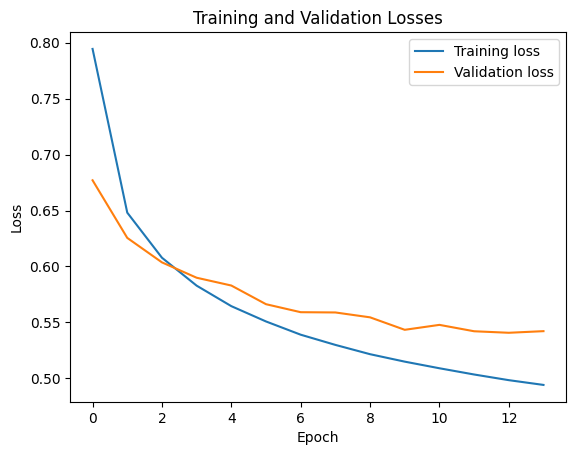

In [44]:
plot_losses(train_losses, val_losses)

In [45]:
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for val_data, val_labels in val_loader:
        val_outputs = model(val_data)
        val_loss += criterion(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

print('Validation loss: {:.4f}'.format(val_loss / len(val_loader)))
print('Validation accuracy: {:.2f}%'.format(100 * correct / total))

Validation loss: 0.5422
Validation accuracy: 78.89%


In [46]:
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for test_data, test_labels in test_loader:
        test_outputs = model(test_data)
        test_loss += criterion(test_outputs, test_labels).item()
        _, predicted = torch.max(test_outputs, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

print('Test loss: {:.4f}'.format(test_loss / len(test_loader)))
print('Test accuracy: {:.2f}%'.format(100 * correct / total))

Test loss: 0.5386
Test accuracy: 78.74%
